In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cqed.analysis import quantum_jumps as qjmps

# a nice library for hidden markov models, used here to generate some benchmarking data
from hmmlearn import hmm

# Generate testing data

In [2]:
def test_data(n_samples, snr, startprob, transition_mtrx, means):
    #fix the random seed to have the same data every time
    np.random.seed(42)

    model = hmm.GaussianHMM(n_components=2, covariance_type="spherical")
    model.startprob_ = startprob
    model.transmat_ = transition_mtrx
    model.means_ = means
    #variance of the blobs
    model.covars_ = (1./snr**2., 1./snr**2.)

    X, Z = model.sample(int(n_samples))
    return X, Z

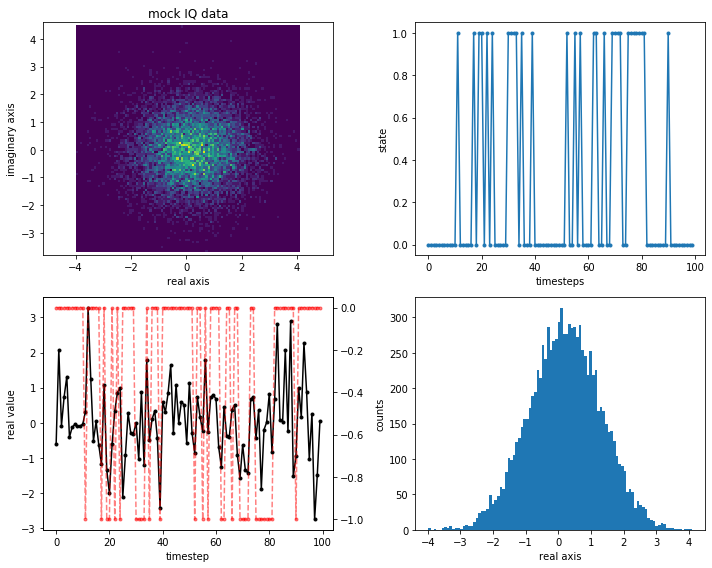

In [4]:
n_samples = 1e4
snr = 1. # defined as distance between means divided by variance, assuming the distance is 1.

startprob = np.array([0.5, 0.5,])

transition_mtrx = np.array([[0.7, 0.3],
                            [0.7, 0.3]])
#blob means
means = np.array([[0.5, 0.0], 
                  [-.5, 0.0]])

X, Z = test_data(n_samples, snr, startprob, transition_mtrx, means)

fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].hist2d(X[:,0], X[:,1], bins=100)
ax[0,0].axis('equal')
ax[0,0].set_xlabel('real axis')
ax[0,0].set_ylabel('imaginary axis')
ax[0,0].set_title('mock IQ data')

ax[0,1].plot(Z[:100], '.-')
ax[0,1].set_xlabel('timesteps')
ax[0,1].set_ylabel('state')

ax[1,0].plot(X[:100,0], 'k.-')
axz = ax[1,0].twinx()
axz.plot(-1.*Z[:100], 'r.--', alpha=0.5)
ax[1,0].set_xlabel('timestep')
ax[1,0].set_ylabel('real value')

hist = ax[1,1].hist(X[:,0], bins=100)
ax[1,1].set_xlabel('real axis')
ax[1,1].set_ylabel('counts')
fig.tight_layout()

# How to use the latching filter pipeline

## Usage

In [102]:
# load your trace data either in complex format or as a tuple of (real, imaginary)

qj = qjmps.QntmJumpTrace(X[:,0]+1.j*X[:,1])
# qj = qjmps.QntmJumpTrace((X[:,0], X[:,1]), complex=False)

################################ 
# perform the entire pipeline: #
################################
# 1) rotate the data for maximum variance
# 2) Histogram the real part of the data and fit a double gaussian
# 3) Run the two point latching-filter algorithm to perform the state assignment
# 4) Histogram the dwell times of the two states and fit an exponential distribution

# For some special cases latching_pipeline has a few kwargs available:
n_bins=100 # number of bins used for the histogram of the real part of the rotated data
dbl_gauss_p0=None # starting parameters for the double gaussian fit
override_gaussfit=False # False: use the parameters found in the 
                        # internal double gauss fit routine for the state assignment algorithm 
                        # True: use the parameters provided through the state_filter_prms kwarg 
                        # for the latching algorithm
state_filter_prms=None  # provide the state filter parameters, 
                        # expects a tuple of ((mu gauss1, mu gauss2), (sigma gauss1, sigma gauss2))
n_sigma_filter=1.0      # threshold for assigning a jump in the latching algorithm is mu - n_sigma_filter * sigma

qj.latching_pipeline(n_bins=n_bins, dbl_gauss_p0=dbl_gauss_p0, override_gaussfit=override_gaussfit, 
                    state_filter_prms=state_filter_prms, n_sigma_filter=n_sigma_filter)

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:211: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:219: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])


## Attributes available after running the pipeline

In [ ]:
# raw input dataset:
####
# qj.raw_data

# rotated complex dataset: 
####
# qj.raw_data_rot 

# histogram of real part of rotated data, tuple: (bin axis, norm. counts). 
# Unlike in a standard regular histogram the bin axis is of same length as the number of counts. 
# Bin axis indicates the center point of each bin, i.e. the bin width is bin_axis[1]-bin_axis[0]
####
# qj.raw_hist 

# fit result of the double gaussian routine
# [scaling1, mu1, sigma1, scaling2, mu2, sigma2]
####
# qj.fitresult_gauss

# extracted state vector
###
# qj.state_vec

# list of extracted dwell times
####
# qj.dwell_l
# qj.dwell_h

# histogram of dwell times as tuple (bin axis, norm. counts)
# same approach for the bin axis as above
# available for both states

# qj.hist_dwell_l
# qj.hist_dwell_h

# fitted parameters of fitting a linear function to the log of the dwell time histograms
# uses scipy.optimize.curve_fit internally
# tuple (fitted parameters, cov matrix)
# fitted parameters = [slope, offset]
####
# qj.rate_lh
# qj.rate_hl

# Benchmarking

## Latching filter

## Influence of n_sigma_filter for constant SNR = 15

In [33]:
snr = 15.
x, z = test_data(n_samples, snr, startprob, transition_mtrx, means)

rate_l = []
rate_h = []

bm_sigs = [0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7]

for n_sg in bm_sigs:
    qj = qjmps.QntmJumpTrace(x[:,0]+1.j*x[:,1])
    qj.latching_pipeline(n_sigma_filter=n_sg)
#     qj.plot_analysis()
    rate_l.append(qj.rate_lh[0][0])
    rate_h.append(qj.rate_hl[0][0])

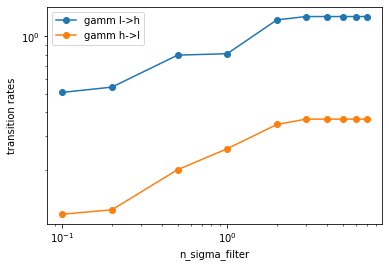

In [36]:
plt.plot(bm_sigs, rate_l, 'o-', label='gamm l->h')
plt.plot(bm_sigs, rate_h, 'o-', label='gamm h->l')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n_sigma_filter')
plt.ylabel('transition rates')
plt.legend()

## Influence of SNR

In [76]:
snrs = np.arange(1, 16, 1)

rate_l = []
rate_h = []

for snr in snrs:
    x, z = test_data(n_samples, snr, startprob, transition_mtrx, means)
    qj = qjmps.QntmJumpTrace(x[:,0]+1.j*x[:,1])
    qj.latching_pipeline()
#     qj.plot_analysis()
    rate_l.append(qj.rate_lh[0][0])
    rate_h.append(qj.rate_hl[0][0])

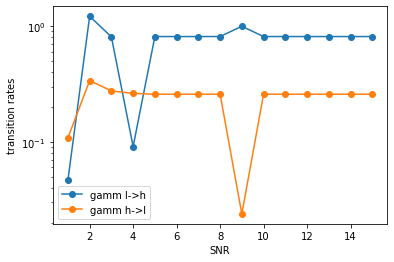

In [77]:
plt.plot(snrs, rate_l, 'o-', label='gamm l->h')
plt.plot(snrs, rate_h, 'o-', label='gamm h->l')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('transition rates')
plt.legend()

## Combined influence

In [83]:
snrs = np.arange(1, 20, 1)

rate_l = np.ones((np.max(snrs), np.max(snrs)))*np.nan
rate_h = np.ones((np.max(snrs), np.max(snrs)))*np.nan

for ind, snr in enumerate(snrs):
    x, z = test_data(n_samples, snr, startprob, transition_mtrx, means)

    for j, n_sigm in enumerate(np.arange(1, snr+1, 1)):
        
        qj = qjmps.QntmJumpTrace(x[:,0]+1.j*x[:,1])
        qj.latching_pipeline(n_sigma_filter=n_sigm/2.)
        try:
            rate_l[ind, j] = qj.rate_lh[0][0]
            rate_h[ind, j] = qj.rate_hl[0][0]
        except TypeError:
            pass

c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:211: RuntimeWarning: divide by zero encountered in log
  log_yl = np.log(self.hist_dwell_l[1])
c:\users\lgrunhaupt\documents\code\stable\cqed\cqed\analysis\quantum_jumps.py:219: RuntimeWarning: divide by zero encountered in log
  log_yh = np.log(self.hist_dwell_h[1])
C:\Users\lgrunhaupt\AppData\Local\Continuum\anaconda3\envs\qcodes\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


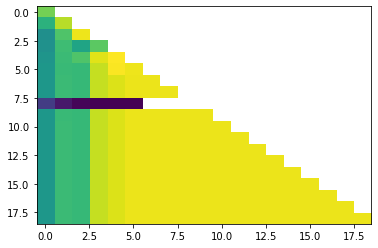

In [84]:
plt.imshow(rate_h, aspect='auto')